In [4]:
import casadi
import numpy as np
from IPython.display import HTML
from bearing_maintenance_mpc import  BearingMaintenanceMPC
from bearing_maintenance_mpc import  dm_to_array
from anim_utils import animate, plot_figure

from shapely.geometry import Polygon, Point
from voronoi import voronoicentroid
from bearing_rigidity_utils import sort_positions_by_nearest_neighbor, get_neighbors_state, get_neighbors_bearing, generate_random_laman_graph
from coverage_utils import calculate_locational_opt_cost
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MPC with Bearing Rigidity, $\mu$ = 1000 

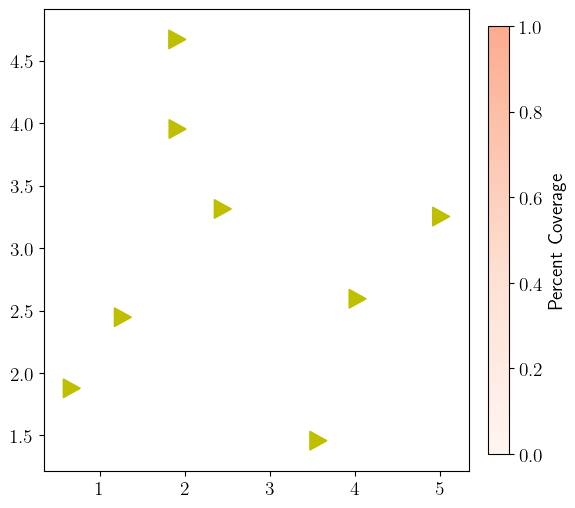

<Figure size 640x480 with 0 Axes>

In [7]:
Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20

v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 8
n_neighbors = np.zeros(n_agents, dtype=int)

positions = 5*np.random.rand(n_agents, 2)
positions = sort_positions_by_nearest_neighbor(positions)
G, adj_matrix = generate_random_laman_graph(n_agents, positions)

agents_init_state = np.hstack((positions, np.zeros((n_agents, 1))))  # Initialize agents at random positions with zero orientation
#agents_init_state = np.array([[0.7, 0.9, 0.0], [0.5, 1.2, 0.0], [2.0, 1.5, 0.0], [1.5, 1.0, 0.0] ])

for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if (adj_matrix[i][j]==1):
            n_neighbors[i]+=1         

t0_list = [0 for i in range(n_agents)]
agents = [BearingMaintenanceMPC(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=1000) for i in range(n_agents)]
ref_state_list = []

state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]

vor_list = []
vcentroids_list = []

p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
vcentroids, vor = voronoicentroid(p, workspace)
vor_list.append(vor)
vcentroids_list.append(vcentroids)    
max_iter = 30
max_time = 5

cost_mu_1000 = []
for k in range(max_iter):
    ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
    for t in range(max_time):
        agent_states = np.array([agents[i].states for i in range(n_agents)])
        cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
        cost_mu_1000.append(cost_)
        for j in range(n_agents):
            neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
            curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
            agent_target_state = ref_states_list[j][0]
            neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
            target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
            u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

        for j in range(n_agents):
            agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
            agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
            t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

    p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
anim_params = {
    'ref_state_list': ref_state_list,
    'agents_init_state':agents_init_state,
    'agents_state_list':agents_state_list,
    'agents_control_list':agents_control_list,
    'obstacles': None,
    'num_frames':max_iter*max_time,
    'max_iter':max_iter,
    'pred_horizon':N,
    'adj_matrix':adj_matrix,
    'vor':vor_list,
    'vcentroids': vcentroids_list,
    'save': False,
    'file_name':'coverage_with_bearing'
}
sim = animate(anim_params)
HTML(sim.to_html5_video())  

### Locational Optimization Cost Comparison with and without Bearing Rigidity

In [8]:
Q_x = 1
Q_y = 1
Q_theta = 1
R_v = 0.5
R_omega = 0.005

dt = 0.1
N = 20

v_lim = [-0.4, 0.4]
omega_lim = [-casadi.pi/4, casadi.pi/4]
Q = [Q_x, Q_y, Q_theta]
R = [R_v, R_omega]

workspace = Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])

n_agents = 4
cost_mu_0_arr = []
cost_mu_1000_arr = []

for i in tqdm(range(10)):
    n_neighbors = np.zeros(n_agents, dtype=int)
    # Generate a random Laman graph adjacency matrix
    positions = 5*np.random.rand(n_agents, 2)
    positions = sort_positions_by_nearest_neighbor(positions)
    G, adj_matrix = generate_random_laman_graph(n_agents, positions)

    agents_init_state = np.hstack((positions, np.zeros((n_agents, 1))))
    #agents_init_state = np.array([[0.7, 0.9, 0.0], [0.5, 1.2, 0.0], [2.0, 1.5, 0.0], [1.5, 1.0, 0.0] ])

    for i in range(adj_matrix.shape[0]):
        for j in range(adj_matrix.shape[1]):
            if (adj_matrix[i][j]==1):
                n_neighbors[i]+=1         

    t0_list = [0 for i in range(n_agents)]

    agents = [BearingMaintenanceMPC(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=0) for i in range(n_agents)]

    state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
    u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

    u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
    agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
    agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]

    vor_list = []
    vcentroids_list = []

    p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
    max_iter = 30
    max_time = 5

    cost_mu_0 = []
    for k in range(max_iter):
        ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
        for t in range(max_time):
            agent_states = np.array([agents[i].states for i in range(n_agents)])
            cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
            cost_mu_0.append(cost_)
            for j in range(n_agents):
                neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
                curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
                agent_target_state = ref_states_list[j][0]
                neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
                target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
                u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

            for j in range(n_agents):
                agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
                agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

        p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
        vcentroids, vor = voronoicentroid(p, workspace)
        
        vor_list.append(vor)
        vcentroids_list.append(vcentroids) 
    cost_mu_0_arr.append(cost_mu_0)  

    
    
    agents = [BearingMaintenanceMPC(agents_init_state[i], n_neighbors[i], dt, N, v_lim, omega_lim, Q, R, obstacles= None, cbf_const=False, mu=1000) for i in range(n_agents)]

    state_0_list = [casadi.DM([agents_init_state[i][0], agents_init_state[i][1], agents_init_state[i][2]]) for i in range(n_agents)]
    u0_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X0_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]

    u_list = [casadi.DM.zeros((agents[i].n_controls, N)) for i in range(n_agents)]
    X_pred_list = [casadi.repmat(state_0_list[i], 1, N + 1) for i in range(n_agents)]
    agents_state_list = [dm_to_array(X0_list[i]) for i in range(n_agents)]
    agents_control_list = [dm_to_array(u0_list[i][:, 0]) for i in range(n_agents)]

    vor_list = []
    vcentroids_list = []

    p = np.array([dm_to_array(X0_list[i])[:2,1] for i in range(n_agents)])
    vcentroids, vor = voronoicentroid(p, workspace)
    vor_list.append(vor)
    vcentroids_list.append(vcentroids)    
    max_iter = 30
    max_time = 5

    cost_mu_1000 = []
    for k in range(max_iter):
        ref_states_list = [np.array([[vcentroids[j][0]], [vcentroids[j][1]], [np.arctan2(vcentroids[j][1] - p[j][1], vcentroids[j][0] - p[j][0])]]).T for j in range(n_agents)]    
        for t in range(max_time):
            agent_states = np.array([agents[i].states for i in range(n_agents)])
            cost_= calculate_locational_opt_cost(agent_states[:, :2], [0,5] , [0,5], 100)
            cost_mu_1000.append(cost_)
            for j in range(n_agents):
                neighbor_states = get_neighbors_state(j, agent_states, adj_matrix)
                curr_bearing = get_neighbors_bearing(agent_states[j], neighbor_states)
                agent_target_state = ref_states_list[j][0]
                neighbor_target_states = get_neighbors_state(j, agent_states, adj_matrix)
                target_bearing = get_neighbors_bearing(agent_target_state, neighbor_target_states)
                u_list[j], X_pred_list[j] = agents[j].solve(X0_list[j], u0_list[j], ref_states_list[j], t, neighbor_states, target_bearing)

            for j in range(n_agents):
                agents_state_list[j] = np.dstack((agents_state_list[j], dm_to_array(X_pred_list[j])))
                agents_control_list[j] = np.dstack((agents_control_list[j], dm_to_array(u_list[j][:, 0])))
                t0_list[j], X0_list[j], u0_list[j] = agents[j].shift_timestep(dt, t0_list[j], X_pred_list[j], u_list[j])

        p = np.array([np.array(X0_list[i])[:2,1] for i in range(n_agents)])
        vcentroids, vor = voronoicentroid(p, workspace)
        
        vor_list.append(vor)
        vcentroids_list.append(vcentroids) 
    cost_mu_1000_arr.append(cost_mu_1000)  

100%|██████████| 10/10 [03:04<00:00, 18.40s/it]


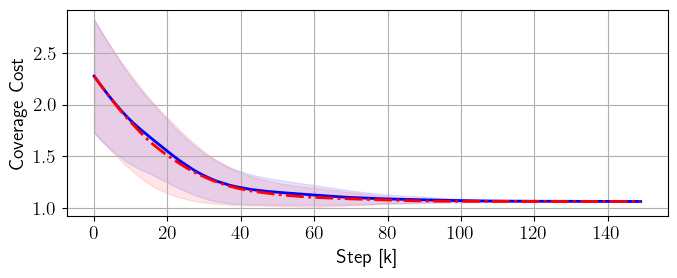

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=[7,3])

cost_mu_0_arr = np.array(cost_mu_0_arr)
cost_mu_1000_arr = np.array(cost_mu_1000_arr)

cost_mu_0_mean = np.mean(cost_mu_0_arr, axis=0)
cost_mu_1000_mean = np.mean(cost_mu_1000_arr, axis=0)


cost_mu_0_std = np.std(cost_mu_0_arr, axis=0)
cost_mu_1000_std = np.std(cost_mu_1000_arr, axis=0)


plt.plot(np.arange(150), cost_mu_0_mean,'-', color = 'b', linewidth = 2)
plt.plot(np.arange(150), cost_mu_1000_mean,'-.', color = 'r', linewidth = 2)
plt.fill_between(np.arange(150), cost_mu_0_mean - cost_mu_0_std, cost_mu_0_mean + cost_mu_0_std, color='b', alpha=.1)
plt.fill_between(np.arange(150), cost_mu_1000_mean - cost_mu_1000_std, cost_mu_1000_mean + cost_mu_1000_std, color='r', alpha=.1)
plt.grid()
plt.ylabel('Coverage Cost')
plt.xlabel('Step [k]')
plt.tight_layout()
#plt.savefig('coverage_cost.pdf')